# Surface Cracking Detection : ResNet50 (Pretrained)

227 X 227 X RGB

20,000 images for Pos/Neg each

Base Model: ResNet50 (pretrained weights by ImageNet)

# 제약 사항

- random seed 821
- train / val / test = 6: 2: 2  (24,000 : 8,000 : 8,000)
- loss function : binary crossentropy
- epoch = Early Stopping (Val_recall max, 10 patience) 

- dropout:  0.1 

- optimizer = MiniBatch SDG, MOMENTUM(모멘텀 계수 0.9), ADAM
- 기본 batch_size = 64 / mini batch SGD의 batch_size = 16 
- lr = 0.1 / 0.01

- model.fit_generator 시 ModelCheckpoint 추가
- metric: Recall (실제 균열을 모델이 균열로 인식한 확률)

라이브러리 임포트

In [ ]:
import sklearn
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model,layers
from keras.metrics import Recall

import numpy as np
import os
from shutil import copyfile

random.seed(821)
tf.random.set_seed(821)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

데이터셋 로드

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'lotusist'
os.environ['KAGGLE_KEY'] = 'bcd624f28f21503e9fb4d315ea3e0e33'

!kaggle datasets download -d arunrk7/surface-crack-detection
!unzip -q surface-crack-detection.zip

 91% 213M/233M [00:01<00:00, 111MB/s]
100% 233M/233M [00:01<00:00, 124MB/s]


In [ ]:
print(len(os.listdir("Positive")))
print(len(os.listdir("Positive")))

20000
20000


In [ ]:
os.mkdir('/tmp/concrete')
os.mkdir('/tmp/concrete/training')
os.mkdir('/tmp/concrete/testing')
os.mkdir('/tmp/concrete/valid')
os.mkdir('/tmp/concrete/training/positive')
os.mkdir('/tmp/concrete/training/negative')
os.mkdir('/tmp/concrete/testing/positive')
os.mkdir('/tmp/concrete/testing/negative')
os.mkdir('/tmp/concrete/valid/positive')
os.mkdir('/tmp/concrete/valid/negative')

In [ ]:
def split_data(SOURCE,TRAINING,VALID,TESTING,TRAINING_SIZE,VALID_SIZE):
    files=[]
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + "is zero length, so ignoring.")
    training_length = int(len(files)*TRAINING_SIZE)
    valid_length = int(len(files)*VALID_SIZE)
    testing_length = int(len(files)-training_length-valid_length)
    shuffled_set = random.sample(files,len(files))
    valid_set = shuffled_set[0:valid_length]
    training_set = shuffled_set[valid_length:-testing_length]
    testing_set = shuffled_set[-testing_length:]
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)
    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file,destination)
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)
        
POSITIVE_SOURCE_DIR = "/content/Positive/"
NEGATIVE_SOURCE_DIR = "/content/Negative/"
TRAINING_POSITIVE_DIR = '/tmp/concrete/training/positive/'  
TRAINING_NEGATIVE_DIR = '/tmp/concrete/training/negative/'   
VALID_POSITIVE_DIR = '/tmp/concrete/valid/positive/'  
VALID_NEGATIVE_DIR = '/tmp/concrete/valid/negative/'   
TESTING_POSITIVE_DIR = '/tmp/concrete/testing/positive/'
TESTING_NEGATIVE_DIR = '/tmp/concrete/testing/negative/'

training_size = 0.6
valid_size = 0.2
split_data(POSITIVE_SOURCE_DIR, TRAINING_POSITIVE_DIR, VALID_POSITIVE_DIR,TESTING_POSITIVE_DIR, training_size, valid_size)
split_data(NEGATIVE_SOURCE_DIR, TRAINING_NEGATIVE_DIR, VALID_NEGATIVE_DIR,TESTING_NEGATIVE_DIR, training_size, valid_size)

In [ ]:
print(len(os.listdir('/tmp/concrete/training/positive/')))
print(len(os.listdir('/tmp/concrete/training/negative/')))
print(len(os.listdir('/tmp/concrete/testing/positive/')))
print(len(os.listdir('/tmp/concrete/testing/negative/')))
print(len(os.listdir('/tmp/concrete/valid/positive/')))
print(len(os.listdir('/tmp/concrete/valid/negative/')))

12000
12000
4000
4000
4000
4000


# ResNet50 적용

In [ ]:
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# 1. Optimizer = Adam

In [ ]:
# Creating ResNet50 (pre-trained weights by imagenet) optimized by Adam

def create_model_ResNet_Adam(learning_rate, dropout):
  pre_trained_model_ResNet = keras.applications.resnet50.ResNet50(weights="imagenet",  # ResNet50 모델 사용. imagenet에서 학습된 weight
                                                  input_shape = (227, 227, 3),  # input shape = (227, 227, 3)
                                                  include_top=False)  # convolution layer만 가져오겠다는 뜻. fully connected layer는 off
  for layer in pre_trained_model_ResNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pre_trained_model_ResNet)
  model.add(layers.GlobalAveragePooling2D()) # 2D로 만들기 
  model.add(layers.Dropout(dropout)) # Dropout
  model.add(layers.Dense(1, activation='sigmoid')) # binary classification이므로 타겟 클래스에 대한 확률 인코딩

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),loss='binary_crossentropy', metrics=["Recall"]) # learning rate
  
  return model

def ResNet_Adam(learning_rate, dropout, epochs):
  model = create_model_ResNet_Adam(learning_rate, dropout)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1./255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1./255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')

  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator, 
                                    epochs=epochs, # 에포크
                                    validation_data=valid_generator, 
                                    verbose =1, 
                                    callbacks = [early_stopping,mc])

  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(rec))

  plt.plot(epochs, rec, 'r', label='Training recall')
  plt.plot(epochs, val_rec, 'b', label='Validation recall')
  plt.title('Training and validation recall')

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')

  plt.legend()

  plt.show()

## 1.1. dropout = 0.1 & learning rate =0.1

94773248/94765736 [==============================] - 0s 0us/step
Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 101s 180ms/step - loss: 1.5529 - recall: 0.6517 - val_loss: 0.3745 - val_recall: 0.6345
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 66s 176ms/step - loss: 0.3562 - recall: 0.8184 - val_loss: 0.1876 - val_recall: 0.9607
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 66s 175ms/step - loss: 0.4080 - recall: 0.8326 - val_loss: 0.1540 - val_recall: 0.9553
Epoch 4/100
375/375 [==============================] - 65s 172ms/step - loss: 0.2662 - recall: 0.8795 - val_loss: 0.1301 - val_recall: 0.9348
Epoch 5/100
375/375 [==============================] - 64s 172ms/step - loss: 0.2709 - recall: 0.8876 - val_loss: 0.1535 - val_recall: 0.8925
Epoch 6/100
375/375 [==============================] - 64s 172ms/step - loss: 0.3128 - recall: 0.8811 - val_loss: 0.1198 - val_recall: 0.9333
Epoch 7/100
375/375 [==========

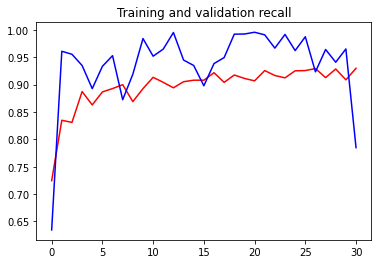

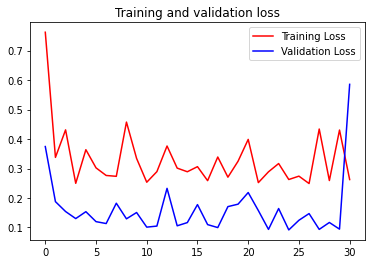

In [ ]:
ResNet_Adam(learning_rate=0.1, dropout=0.1, epochs=100)

## 1.2. dropout = 0.1 & learning rate = 0.01

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 70s 175ms/step - loss: 0.6838 - recall: 0.5987 - val_loss: 0.4793 - val_recall: 0.4750
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 65s 174ms/step - loss: 0.4438 - recall: 0.7909 - val_loss: 0.3299 - val_recall: 0.8447
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 65s 173ms/step - loss: 0.3711 - recall: 0.8177 - val_loss: 0.2842 - val_recall: 0.8600
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/100
375/375 [==============================] - 65s 174ms/step - loss: 0.3201 - recall: 0.8476 - val_loss: 0.2537 - val_recall: 0.8995
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
375/375 [==============================] - 65s 174ms/step - loss: 0.2878 - recall: 0.8602 - val_loss: 0.2316 - val_recall: 0.8945
Epoch 6/100
375/375 [==============================] - 65s

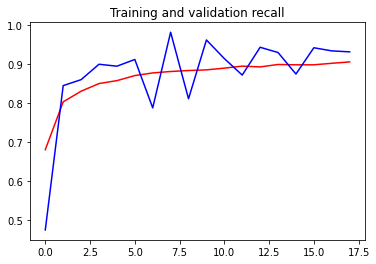

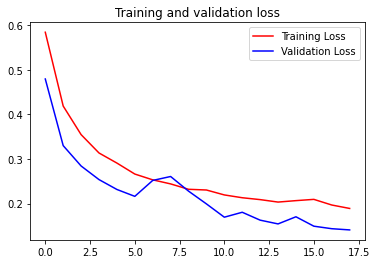

In [ ]:
ResNet_Adam(learning_rate=0.01, dropout=0.1, epochs=100)

# 2. Optimizer = MiniBatch SDG

In [ ]:
# optimized by SGD with Mini Batch (size 16)

def create_model_ResNet_MBSGD(learning_rate, dropout):
  pre_trained_model_ResNet = keras.applications.resnet50.ResNet50(weights="imagenet",  # ResNet50 모델 사용. imagenet에서 학습된 weight
                                                  input_shape = (227, 227, 3),  # input shape = (227, 227, 3)
                                                  include_top=False)  # convolution layer만 가져오겠다는 뜻. fully connected layer는 off
  for layer in pre_trained_model_ResNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pre_trained_model_ResNet)
  model.add(layers.GlobalAveragePooling2D()) # 2D로 만들기 
  model.add(layers.Dropout(dropout)) # Dropout
  model.add(layers.Dense(1, activation='sigmoid')) # binary classification이므로 타겟 클래스에 대한 확률 인코딩

  model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate),loss='binary_crossentropy', metrics=["Recall"]) # learning rate

  return model

def ResNet_MBSGD(learning_rate, dropout, epochs):
  model = create_model_ResNet_MBSGD(learning_rate, dropout)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1./255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1./255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')

  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator, 
                                    epochs=epochs, # 에포크
                                    validation_data=valid_generator, 
                                    verbose =1, 
                                    callbacks = [early_stopping,mc])


  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(rec))

  plt.plot(epochs, rec, 'r', label='Training recall')
  plt.plot(epochs, val_rec, 'b', label='Validation recall')
  plt.title('Training and validation recall')

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')

  plt.legend()

  plt.show()

## 2.1. dropout = 0.1 & learning rate =0.1

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1500/1500 [==============================] - 83s 53ms/step - loss: 8.1901 - recall: 0.5188 - val_loss: 10.3236 - val_recall: 0.0000e+00
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
1500/1500 [==============================] - 79s 52ms/step - loss: 7.5121 - recall: 0.5301 - val_loss: 0.2472 - val_recall: 0.8170
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
1500/1500 [==============================] - 79s 52ms/step - loss: 6.8283 - recall: 0.5457 - val_loss: 14.8978 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/100
1500/1500 [==============================] - 79s 52ms/step - loss: 6.4648 - recall: 0.5641 - val_loss: 13.9168 - val_recall: 0.0000e+00
Epoch 5/100
1500/1500 [==============================] - 79s 52ms/step - loss: 6.2224 - recall: 0.5566 - val_loss: 5.2728 - val_recall: 1.0000
Epoch 6/100
1500/1500 [==============================] - 79s 52ms/step - loss: 5.4868 - recall: 0.58

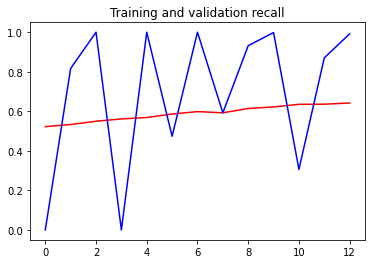

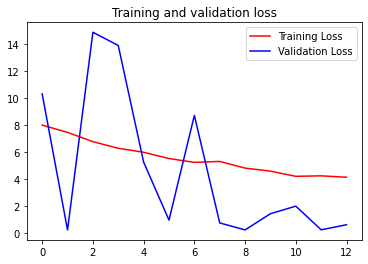

In [ ]:
ResNet_MBSGD(learning_rate=0.1, dropout=0.1, epochs=100)

## 2.2. dropout = 0.1 & learning rate = 0.01

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1500/1500 [==============================] - 82s 53ms/step - loss: 0.8170 - recall: 0.5242 - val_loss: 0.6399 - val_recall: 0.0597
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
1500/1500 [==============================] - 79s 52ms/step - loss: 0.7541 - recall: 0.5594 - val_loss: 0.6138 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
1500/1500 [==============================] - 79s 52ms/step - loss: 0.7109 - recall: 0.5913 - val_loss: 0.6549 - val_recall: 0.0320
Epoch 4/100
1500/1500 [==============================] - 79s 52ms/step - loss: 0.6799 - recall: 0.6100 - val_loss: 0.6149 - val_recall: 1.0000
Epoch 5/100
1500/1500 [==============================] - 79s 52ms/step - loss: 0.6537 - recall: 0.6426 - val_loss: 0.5227 - val_recall: 0.8095
Epoch 6/100
1500/1500 [==============================] - 78s 52ms/step - loss: 0.6462 - recall: 0.6325 - val_loss: 0.5163 - val_recall: 0.6195
Epoch 7/100
1500/1500 [===============

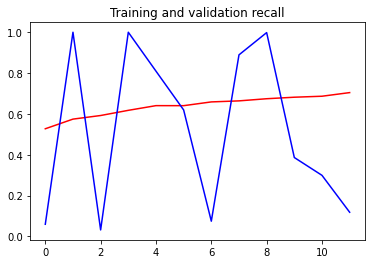

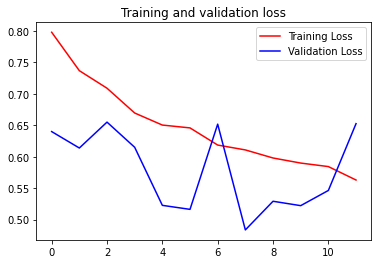

In [ ]:
ResNet_MBSGD(learning_rate=0.01, dropout=0.1, epochs=100)

# 3. Optimizer = Momentum

In [ ]:
# optimized by SGD with Momentum (0.9)

def create_model_ResNet_MoMSGD(learning_rate, dropout):
  pre_trained_model_ResNet = keras.applications.resnet50.ResNet50(weights="imagenet",  # ResNet50 모델 사용. imagenet에서 학습된 weight
                                                  input_shape = (227, 227, 3),  # input shape = (227, 227, 3)
                                                  include_top=False)  # convolution layer만 가져오겠다는 뜻. fully connected layer는 off
  for layer in pre_trained_model_ResNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pre_trained_model_ResNet)
  model.add(layers.GlobalAveragePooling2D()) # 2D로 만들기 
  model.add(layers.Dropout(dropout)) # Dropout
  model.add(layers.Dense(1, activation='sigmoid')) # binary classification이므로 타겟 클래스에 대한 확률 인코딩

  model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9),loss='binary_crossentropy', metrics=["Recall"]) # learning rate

  return model

def ResNet_MoMSGD(learning_rate, dropout, epochs):
  model = create_model_ResNet_MoMSGD(learning_rate, dropout)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1./255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1./255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')

  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator, 
                                    epochs=epochs, # 에포크
                                    validation_data=valid_generator, 
                                    verbose =1, 
                                    callbacks = [early_stopping,mc])


  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(rec))

  plt.plot(epochs, rec, 'r', label='Training recall')
  plt.plot(epochs, val_rec, 'b', label='Validation recall')
  plt.title('Training and validation recall')

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')

  plt.legend()

  plt.show()

## 3.1. dropout = 0.1 & learning rate =0.1

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 70s 176ms/step - loss: 13.5510 - recall: 0.5232 - val_loss: 4.4148 - val_recall: 0.0012
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 65s 174ms/step - loss: 8.6316 - recall: 0.5567 - val_loss: 21.4925 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 65s 172ms/step - loss: 9.6275 - recall: 0.5661 - val_loss: 2.6178 - val_recall: 1.0000
Epoch 4/100
375/375 [==============================] - 65s 173ms/step - loss: 5.7791 - recall: 0.6207 - val_loss: 2.5744 - val_recall: 0.9998
Epoch 5/100
375/375 [==============================] - 65s 173ms/step - loss: 2.9716 - recall: 0.6854 - val_loss: 0.2454 - val_recall: 0.9245
Epoch 6/100
375/375 [==============================] - 64s 172ms/step - loss: 3.8244 - recall: 0.6500 - val_loss: 4.4256 - val_recall: 0.1032
Epoch 7/100
375/375 [=========

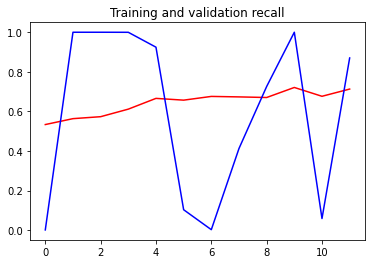

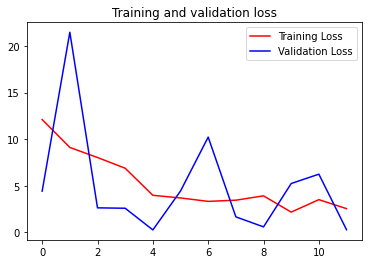

In [ ]:
ResNet_MoMSGD(learning_rate=0.1, dropout=0.1, epochs=100)

## 3.2. dropout = 0.1 & learning rate = 0.01

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 69s 176ms/step - loss: 0.7533 - recall: 0.5208 - val_loss: 0.7483 - val_recall: 7.5000e-04
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 65s 174ms/step - loss: 0.6988 - recall: 0.5915 - val_loss: 0.5462 - val_recall: 0.9975
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 65s 173ms/step - loss: 0.6637 - recall: 0.6170 - val_loss: 0.9303 - val_recall: 0.0015
Epoch 4/100
375/375 [==============================] - 65s 173ms/step - loss: 0.6885 - recall: 0.6319 - val_loss: 0.4634 - val_recall: 0.7770
Epoch 5/100
375/375 [==============================] - 65s 173ms/step - loss: 0.6093 - recall: 0.6699 - val_loss: 0.8685 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 6/100
375/375 [==============================] - 65s 174ms/step - loss: 0.5888 - recall: 0.6954 - val_loss

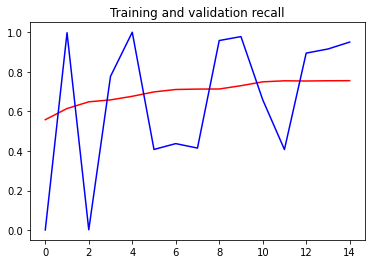

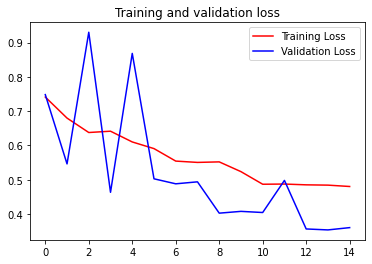

In [ ]:
ResNet_MoMSGD(learning_rate=0.01, dropout=0.1, epochs=100)

# The Best Model of ResNet50
 - Optimizer: Adam
 - Dropout: 0.1
 - learning rate: 0.1